In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from pyro.infer import Predictive
import torch
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from tqdm.autonotebook import tqdm
from IPython.display import clear_output
import os

In [2]:
%load_ext autoreload
%autoreload 2
from __init__ import root_dir, data_path, src_path

In [3]:
os.path.abspath(root_dir)

'/home/gpanagioto/GitHub/MBML/mbml-predictive-maintenance'

In [6]:
%load_ext autoreload
%autoreload 2
from src.models.models import compute_error, model
from src.visualization.visualize import true_vs_preds_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
data = pd.read_csv(os.path.join(data_path,'processed','data_processed.csv'))

In [8]:
data.columns

Index(['Unnamed: 0', 'machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life', 'age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4',
       'failure', 'comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail'],
      dtype='object')

In [9]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.dropna(axis=0, inplace=True)

In [10]:
data['datetime'] = pd.to_datetime(data['datetime'])

Try linear regression with one target variable, the continuous variable `comp1_life`:

In [11]:
cols = ['voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count','age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4','comp2_life']

data_tst = data[cols]

In [12]:
data_tst.shape

(4409, 27)

In [13]:
X = data_tst.to_numpy()

# Keep the last column as target y
y = X[:,-1]
X = X[:,:-1]

In [14]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.1, random_state=0)

print(f"X_train: {X_train_.shape}")
print(f"y_train: {y_train_.shape}")

print(f"X_test: {X_test_.shape}")
print(f"y_test: {y_test_.shape}")

X_train: (3968, 26)
y_train: (3968,)
X_test: (441, 26)
y_test: (441,)


In [15]:
X_mean = X_train_.mean(axis=0)
X_std = X_train_.std(axis=0)

y_std = y_train_.std()
y_mean = y_train_.mean()

In [16]:
X_train = (X_train_ - X_mean)/X_std
X_test = (X_test_- X_mean)/X_std 

y_train = (y_train_- y_mean)/y_std 
y_test = (y_test_- y_mean)/y_std 

In [17]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (3968, 26)
y_train shape: (3968,)


In [18]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

In [35]:
# Define the number of optimization steps
n_steps = 40000

# Setup the optimizer
adam_params = {"lr": 0.0001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

In [36]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 1000 == 0:
#         clear_output(wait=0.01)
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 4981.7
[1000] ELBO: 4987.9
[2000] ELBO: 4979.9
[3000] ELBO: 4980.6
[4000] ELBO: 4985.3
[5000] ELBO: 4980.4
[6000] ELBO: 4984.9
[7000] ELBO: 4982.0
[8000] ELBO: 4981.1
[9000] ELBO: 4981.2
[10000] ELBO: 4985.4
[11000] ELBO: 4982.5
[12000] ELBO: 4985.8
[13000] ELBO: 4983.6
[14000] ELBO: 4980.4
[15000] ELBO: 4981.1
[16000] ELBO: 4981.4
[17000] ELBO: 4981.9
[18000] ELBO: 4983.9
[19000] ELBO: 4982.1
[20000] ELBO: 4982.1
[21000] ELBO: 4982.8
[22000] ELBO: 4979.8
[23000] ELBO: 4982.7
[24000] ELBO: 4983.0
[25000] ELBO: 4982.4
[26000] ELBO: 4981.7
[27000] ELBO: 4981.2
[28000] ELBO: 4982.3
[29000] ELBO: 4981.4
[30000] ELBO: 4982.1
[31000] ELBO: 4981.5
[32000] ELBO: 4981.7
[33000] ELBO: 4982.2
[34000] ELBO: 4981.0
[35000] ELBO: 4982.5
[36000] ELBO: 4979.6
[37000] ELBO: 4981.9
[38000] ELBO: 4981.3
[39000] ELBO: 4982.1


In [37]:
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [38]:
y_std, y_mean

(32.56728848489323, 24.77016129032258)

In [39]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat_train = np.mean(alpha_samples.T + np.dot(X_train, beta_samples[:,0].T), axis=1) 
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)

# convert back to the original scale
preds = y_hat * y_std + y_mean
preds_train = y_hat_train*y_std + y_mean
y_true = y_test * y_std + y_mean

In [40]:
corr, mae, rae, rmse, r2, y_true, preds = compute_error(y_true, preds, None)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

No threshold
CorrCoef: 0.598
MAE: 16.137
RMSE: 23.925
R2: 0.357


In [41]:
figures_path = os.path.abspath(os.path.join(root_dir,'reports','figures'))

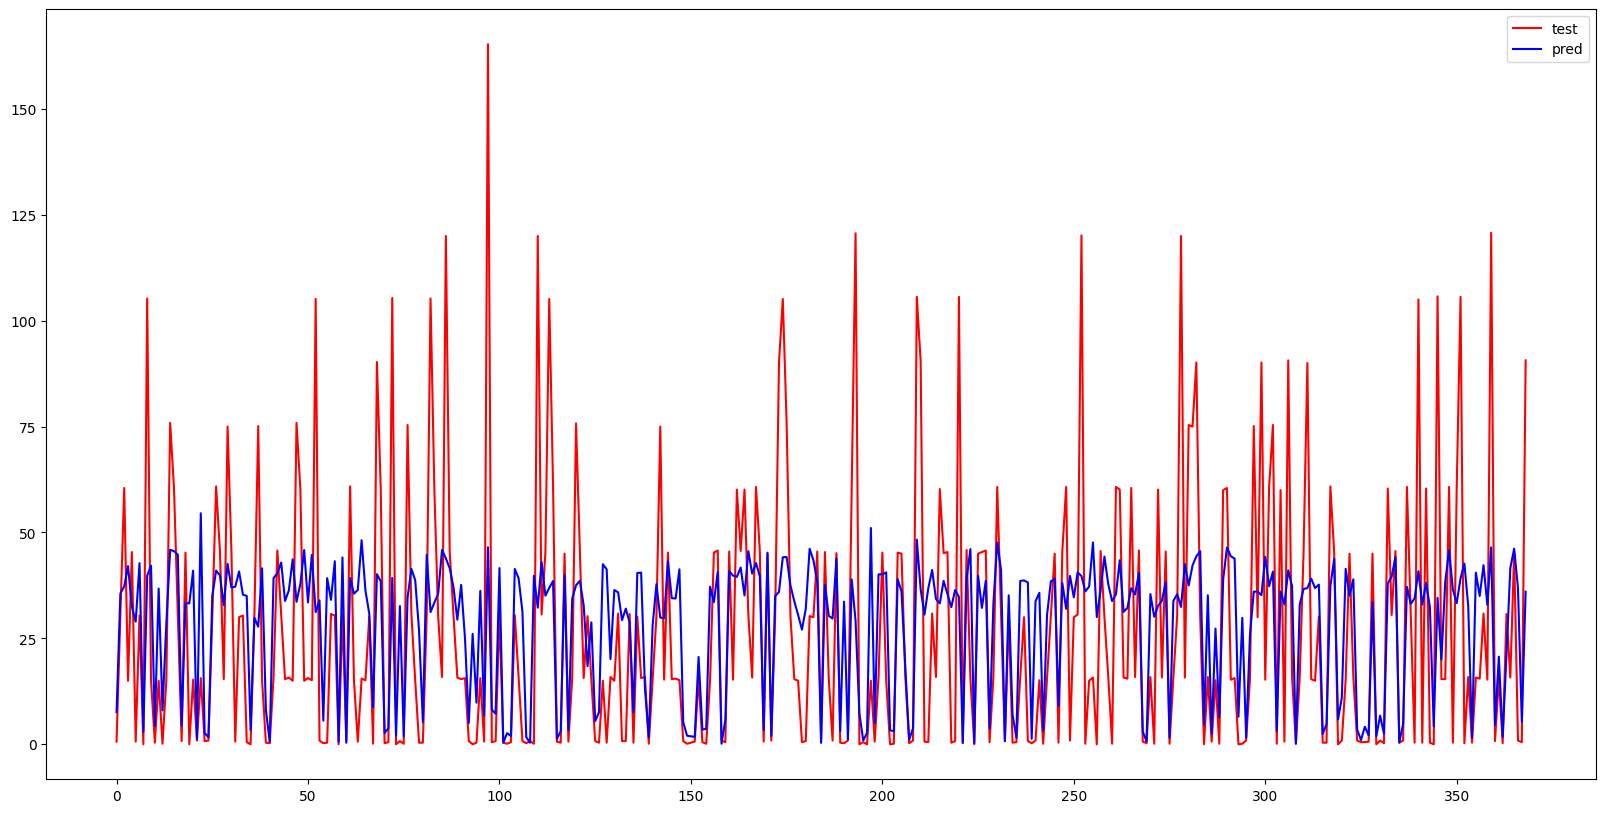

In [42]:
true_vs_preds_plot(y_true, preds, window=None, fig_path=figures_path, name = 'svi_100_test')

In [43]:
corr, mae, rae, rmse, r2, yy_true, ppreds = compute_error(y_true, preds, 60)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.707
MAE: 11.385
RMSE: 15.810
R2: 0.000


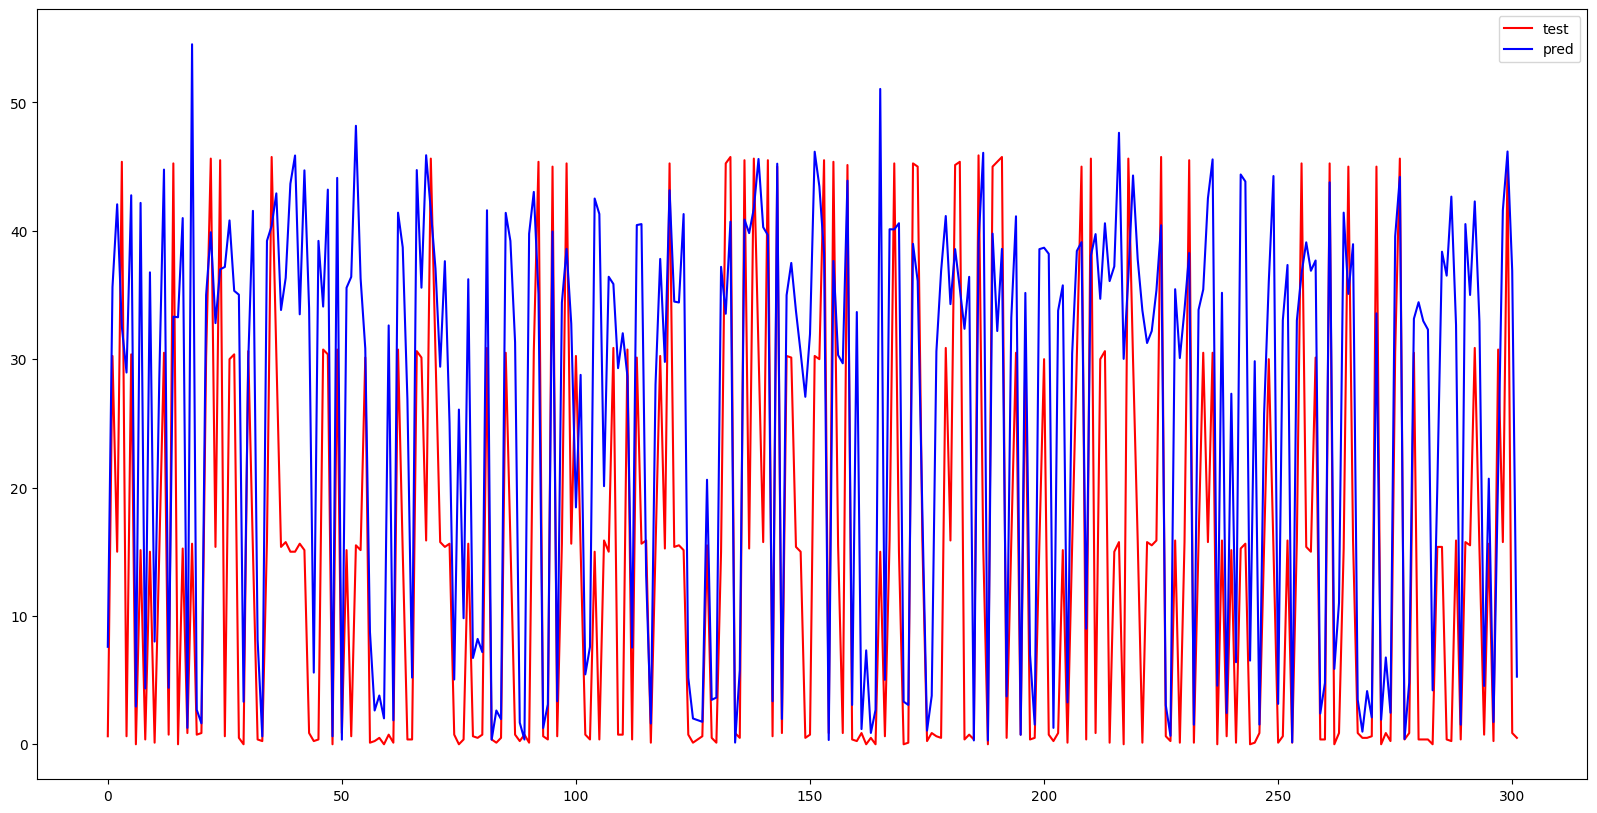

In [44]:
true_vs_preds_plot(yy_true, ppreds, window=None, fig_path=figures_path, name = 'svi_60_test')